<a href="https://colab.research.google.com/github/cabanillapril/AI/blob/main/A2_Time_Series_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bernal, Almarc

Bodano, Ken Jasmer

Cabanilla, April Anne

Francisco, Aldwin Rex

Lim, Anna Grace



# Time Series Forecasting with LSTM
Perform time series forecasting using an LSTM model on the International Airline Passengers Dataset, including data preprocessing, model training, prediction, and evaluation.

## Load and Inspect Dataset

Load the International Airline Passengers Dataset and perform initial inspection to understand its structure and identify any missing values.



The first step is to load the dataset, parse the 'Month' column as datetime objects, and set it as the index. Then, display the first 5 rows, print the DataFrame's info to check data types and non-null values, and finally, check for any missing values.



In [ ]:
import pandas as pd
import os

# Define the file path and URL
file_path = 'airline-passengers.csv'
file_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

# Always download the file to ensure it's fresh and not corrupted from previous attempts
print(f"Downloading {file_path}...")
# Use -O flag to explicitly specify the output filename and remove -q for verbose output
!wget -O $file_path $file_url
print(f"{file_path} downloaded.")

# Debugging: Check file content to ensure it's properly downloaded
print(f"\nVerifying content of {file_path}:")
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes")
    if file_size > 0:
        print("First 5 lines:")
        !head -n 5 $file_path
        print("\nLast 5 lines:")
        !tail -n 5 $file_path
        print("\nTotal lines:")
        !wc -l $file_path
    else:
        print("Error: File is empty after download.")
else:
    print("Error: File does not exist after download.")

# 1.2. Load the 'international-airline-passengers.csv' dataset into a pandas DataFrame.
# Load data by letting pandas infer the header from the first row (header=0).
# Then, manually remove the footer, rename columns, parse dates, and set the index.
# Only proceed if the file is confirmed to have content.
if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    df = pd.read_csv(file_path, header=0)

    # Remove the last row which is the footer (e.g., 'by Data.World (public domain)').
    df = df.iloc[:-1]


    # The actual column name might be '#Passengers' or similar, so we rename it explicitly.
    df = df.rename(columns={'"#Passengers"': 'Passengers', '#Passengers': 'Passengers'}) # Handle both quoted and unquoted header

    # Parse 'Month' column as datetime objects and set it as the index
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index('Month')

    # Convert 'Passengers' column to numeric. Ensure it's not object type.
    df['Passengers'] = pd.to_numeric(df['Passengers'])

    # 1.3. Display the first 5 rows of the DataFrame.
    print("\nFirst 5 rows of the DataFrame:")
    print(df.head())

    # 1.4. Print the concise summary of the DataFrame.
    print("\nDataFrame Info:")
    df.info()

    # 1.5. Check for any missing values.
    print("\nMissing values per column:")
    print(df.isnull().sum())
else:
    print("\nSkipping DataFrame loading and processing due to empty or missing file.")
    df = pd.DataFrame() # Initialize an empty DataFrame to avoid NameError if df is used later

--2025-12-07 13:22:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-12-07 13:22:55 (25.3 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]

airline-passengers.csv downloaded.

Verifying content of airline-passengers.csv:
File size: 2180 bytes
First 5 lines:
"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129

Last 5 lines:
"1960-08",606
"1960-09",508
"1960-10",461
"1960-11",390
"1960-12",432
Total lines:
144 airline-passengers.csv

First 5 rows of the DataFrame:
            Passengers
Month           

## Preprocess Data for LSTM

Scale the passenger data, create sequences (e.g., look-back window), and split the dataset into training and testing sets suitable for an LSTM model.



The previous code successfully loaded the dataset. Now, we will start preprocessing the data for the LSTM model by extracting the 'Passengers' column, scaling it, creating sequences for the LSTM model, splitting the data into training and testing sets, and reshaping the data to fit the LSTM input requirements.



In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 2.2. Extract the 'Passengers' column and convert it to a NumPy array
dataset = df['Passengers'].values

# Reshape the dataset to be 2D for scaling (MinMaxScaler expects 2D array)
dataset = dataset.reshape(-1, 1)

# 2.3. Apply Min-Max scaling to the 'Passengers' data
scholar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scholar.fit_transform(dataset)

# 2.4. Define a function to create sequences for the LSTM model
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 2.5. Apply the sequence creation function to the scaled data
look_back = 1 # Using a look_back window of 1 as a common starting point
X, y = create_dataset(scaled_data, look_back)

# 2.6. Split the sequenced data into training and testing sets (chronological split)
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# 2.7. Reshape input data (X_train, X_test) for LSTM: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("Original dataset shape:", dataset.shape)
print("Scaled data shape:", scaled_data.shape)
print("X (features) shape after sequence creation:", X.shape)
print("y (targets) shape after sequence creation:", y.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Scaler object stored for inverse transformation.")

Original dataset shape: (143, 1)
Scaled data shape: (143, 1)
X (features) shape after sequence creation: (141, 1)
y (targets) shape after sequence creation: (141,)
X_train shape: (94, 1, 1)
y_train shape: (94,)
X_test shape: (47, 1, 1)
y_test shape: (47,)
Scaler object stored for inverse transformation.


## Exploratory Data Analysis


Perform initial exploratory data analysis on the 'Passengers' data by visualizing the time series to identify trends, seasonality, and any unusual patterns.


Visualizing the raw time series data is a fundamental step in exploratory data analysis. It allows for direct observation of key characteristics such as overall trends (increasing/decreasing), seasonal patterns (repeating cycles), and any outliers or sudden changes. This visual inspection helps in forming hypotheses about the data generating process and in guiding subsequent preprocessing and modeling choices.

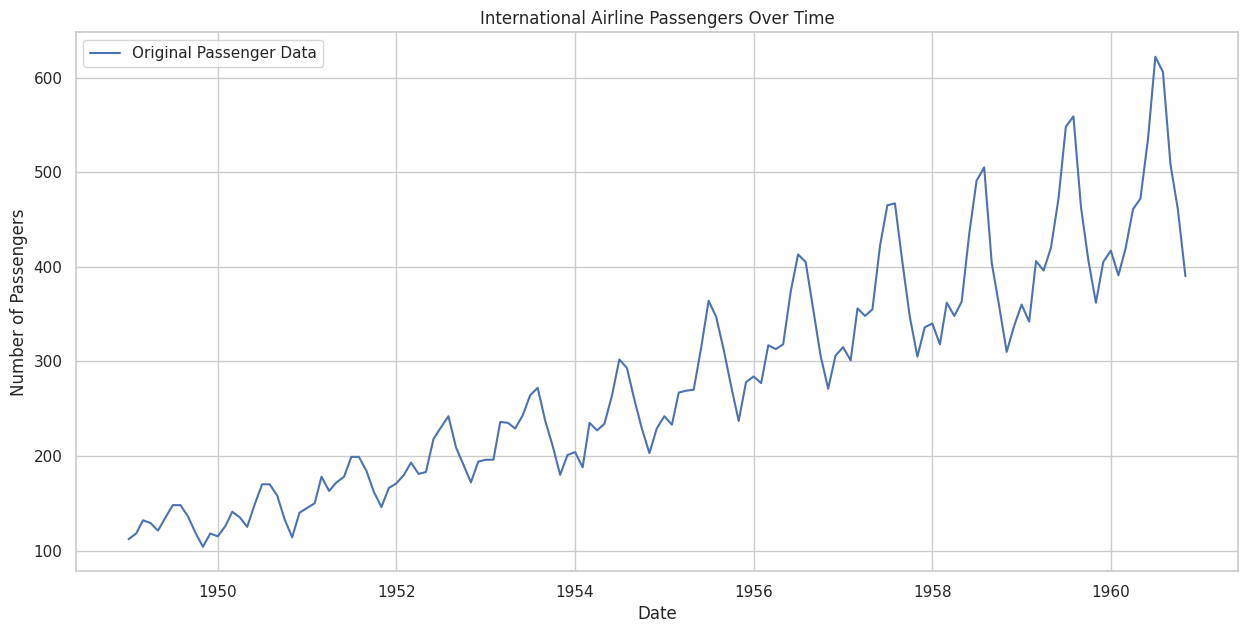

Original time series plot generated.


In [ ]:
import matplotlib.pyplot as plt

# Plot the original 'Passengers' data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Passengers'], label='Original Passenger Data')
plt.title('International Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.legend()
plt.show()

print("Original time series plot generated.")

## Build LSTM Model


Define and compile an LSTM (Long Short-Term Memory) neural network model using TensorFlow Keras with appropriate layers and parameters for time series forecasting.



The subtask is to define and compile an LSTM model. This involves importing necessary Keras modules, building a Sequential model with LSTM and Dense layers, and then compiling it with an optimizer and loss function, finally printing the summary.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 3.2. Instantiate a Sequential model
model = Sequential()

# 3.3. Add an LSTM layer
# Using 4 units as specified, and input_shape derived from X_train dimensions
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2])))

# 3.4. Add a Dense output layer with 1 unit
model.add(Dense(1))

# 3.5. Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# 3.6. Print the model summary
print("LSTM Model Summary:")
model.summary()

LSTM Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)


The previous code successfully built and compiled the LSTM model. The next logical step is to train the model using the prepared training data. This involves calling the `fit` method on the model with the training features (`X_train`), training targets (`y_train`), and appropriate hyperparameters like `epochs` and `batch_size`.



In [ ]:
print("Training the LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=1,
    validation_data=(X_test, y_test),
    verbose=2
)
print("Model training complete.")

Training the LSTM model...
Epoch 1/100
94/94 - 2s - 20ms/step - loss: 0.0338 - val_loss: 0.1940
Epoch 2/100
94/94 - 0s - 3ms/step - loss: 0.0163 - val_loss: 0.1419
Epoch 3/100
94/94 - 0s - 3ms/step - loss: 0.0136 - val_loss: 0.1225
Epoch 4/100
94/94 - 0s - 4ms/step - loss: 0.0124 - val_loss: 0.1122
Epoch 5/100
94/94 - 0s - 3ms/step - loss: 0.0115 - val_loss: 0.1007
Epoch 6/100
94/94 - 0s - 4ms/step - loss: 0.0105 - val_loss: 0.0925
Epoch 7/100
94/94 - 0s - 4ms/step - loss: 0.0095 - val_loss: 0.0792
Epoch 8/100
94/94 - 0s - 3ms/step - loss: 0.0082 - val_loss: 0.0708
Epoch 9/100
94/94 - 0s - 4ms/step - loss: 0.0071 - val_loss: 0.0573
Epoch 10/100
94/94 - 1s - 8ms/step - loss: 0.0060 - val_loss: 0.0435
Epoch 11/100
94/94 - 1s - 7ms/step - loss: 0.0047 - val_loss: 0.0362
Epoch 12/100
94/94 - 1s - 6ms/step - loss: 0.0038 - val_loss: 0.0289
Epoch 13/100
94/94 - 1s - 6ms/step - loss: 0.0030 - val_loss: 0.0179
Epoch 14/100
94/94 - 0s - 4ms/step - loss: 0.0026 - val_loss: 0.0151
Epoch 15/100
94

## Visualize Training History

This code plots how the training and validation loss of the LSTM model changed over each epoch, showing how well the model learned over time and whether it improved on both the training and test data.

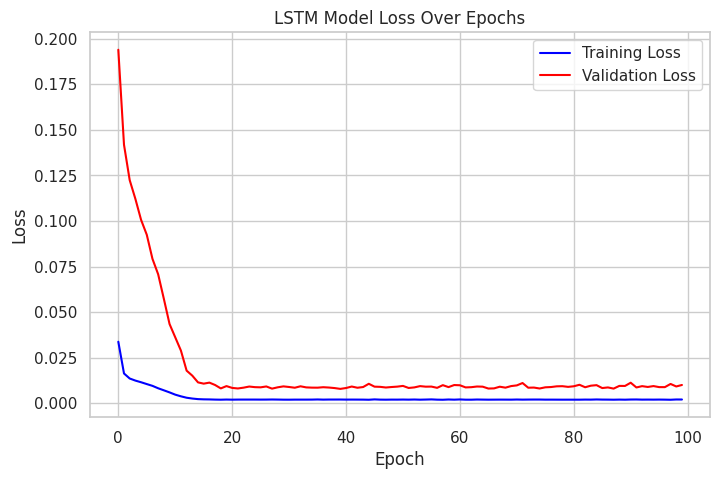

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Analyze Prediction Errors


Visualize the residuals (prediction errors) for both training and testing datasets to understand the model's performance over time.


Visualizing prediction errors (residuals) helps in understanding the model's bias and variance across the dataset. A residual plot can reveal patterns in errors, indicating potential issues like heteroscedasticity or systematic under/over-prediction, which are not immediately obvious from RMSE alone. This plot will show the difference between actual and predicted values over time for both training and test sets.

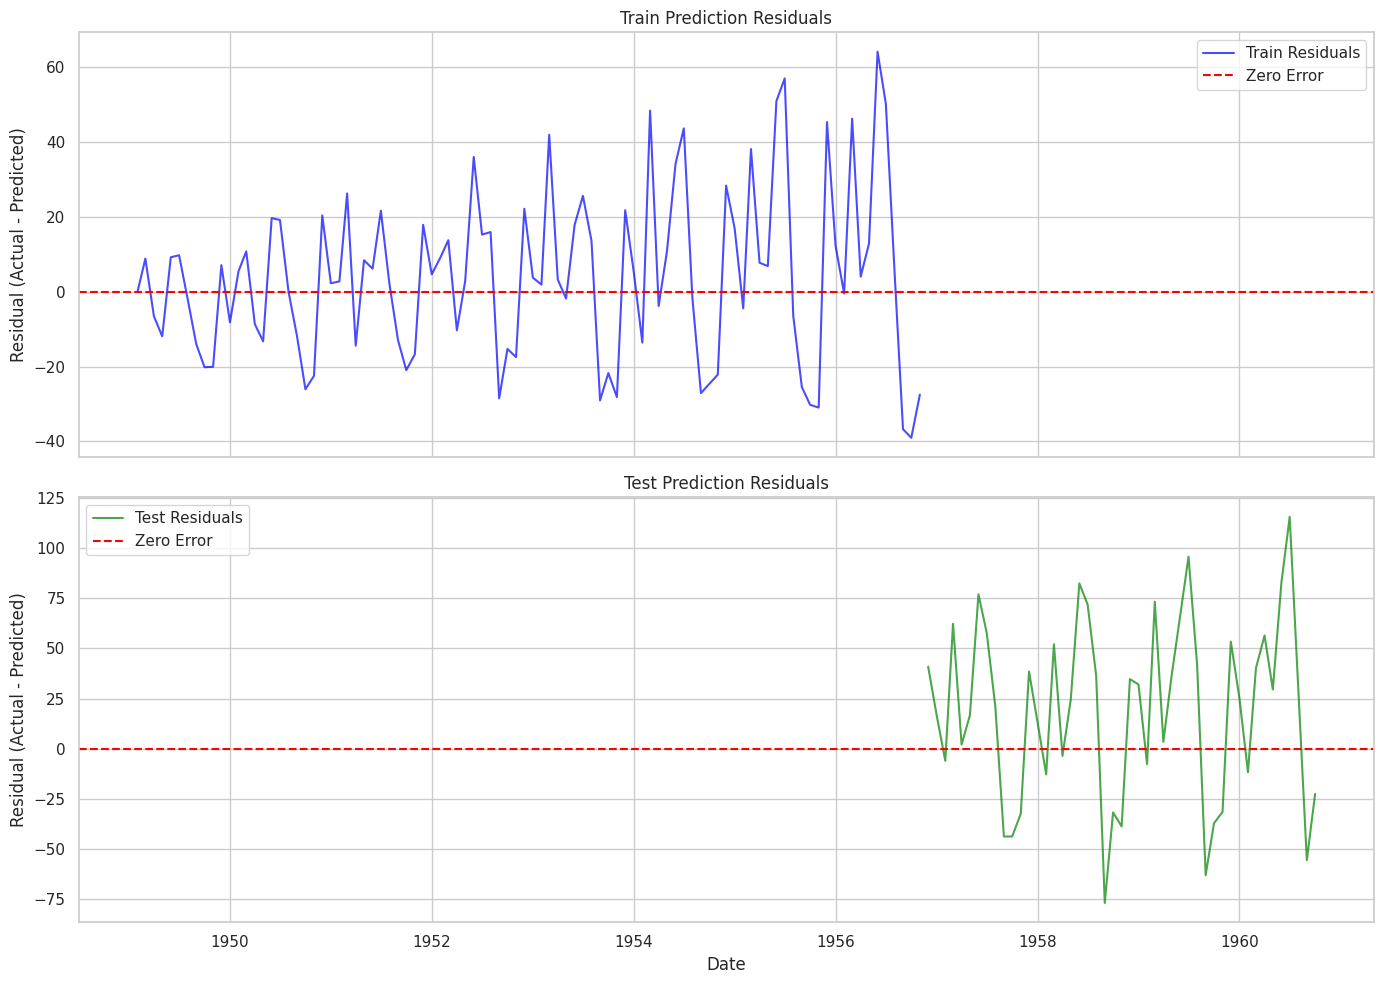

Residuals visualization complete.


In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
train_residuals = y_train_inverse[0] - train_predict[:,0]
test_residuals = y_test_inverse[0] - test_predict[:,0]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot training residuals
axes[0].plot(df.index[look_back:look_back + len(train_residuals)], train_residuals, label='Train Residuals', color='blue', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', label='Zero Error')
axes[0].set_title('Train Prediction Residuals')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].legend()
axes[0].grid(True)

# Plot testing residuals
axes[1].plot(df.index[look_back + len(train_predict) : look_back + len(train_predict) + len(test_residuals)], test_residuals, label='Test Residuals', color='green', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', label='Zero Error')
axes[1].set_title('Test Prediction Residuals')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("Residuals visualization complete.")

## Autocorrelation Function (ACF) Plot


Generate an Autocorrelation Function (ACF) plot for the 'Passengers' data to identify any underlying seasonality or trends.


The ACF plot provides insights into the correlation of a time series with its own past values. Significant spikes at certain lags can indicate seasonality or other repeating patterns, which are crucial characteristics of time series data. This can help confirm visual observations from the raw data plot and suggest appropriate model parameters, such as the `look_back` window.

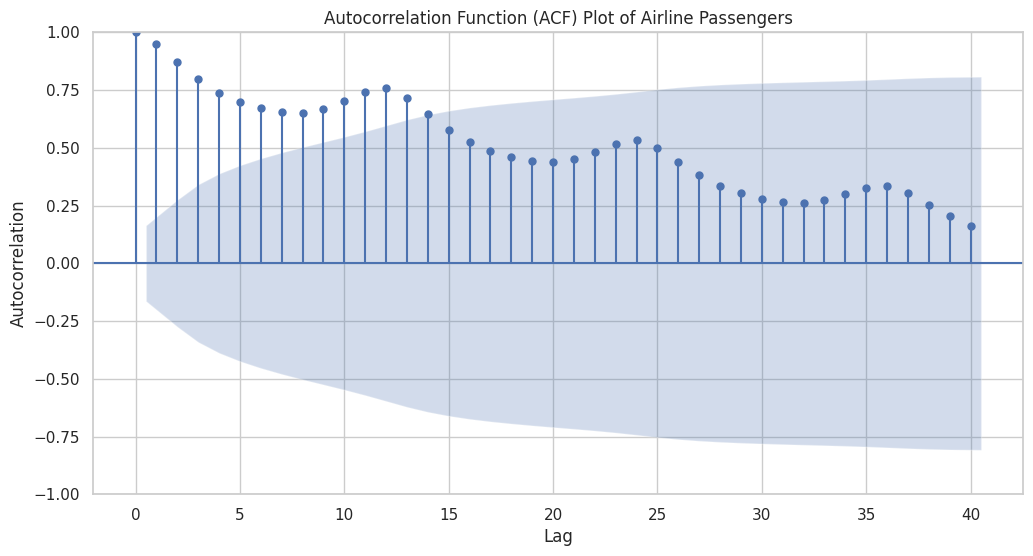

ACF plot generated.


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Create the ACF plot for the original 'Passengers' data
plt.figure(figsize=(12, 6))
plot_acf(df['Passengers'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Plot of Airline Passengers')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("ACF plot generated.")

## Regression Metrics

In our project, which focuses on time series forecasting, we use regression techniques to predict continuous numerical values, such as the number of airline passengers over time. To evaluate the performance of our model, we employ several regression metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²). MAE measures the average absolute difference between the predicted and actual values, providing an easily interpretable error in the same units as the data. MSE calculates the average of squared differences, penalizing larger deviations more heavily, while RMSE is the square root of MSE, expressing the error in the original scale of the target variable. R², or the coefficient of determination, assesses how well our model explains the variance in the data, with values closer to 1 indicating a better fit.


These metrics are calculated for both the training and test sets. The training metrics evaluate our model’s fit on the data it has seen, while the test metrics assess its ability to generalize to unseen data. Ideally, low values of MAE, MSE, and RMSE, combined with high R² values, indicate that our regression-based time series forecasting model is accurate and reliable for predicting future values.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("\n--- Regression Metrics ---")

# Calculate metrics for training set
train_mae = mean_absolute_error(y_train_inverse[0], train_predict[:,0])
train_mse = mean_squared_error(y_train_inverse[0], train_predict[:,0])
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_inverse[0], train_predict[:,0])

print("\nTraining Set Metrics:")
print(f"  MAE: {train_mae:.2f}")
print(f"  MSE: {train_mse:.2f}")
print(f"  RMSE: {train_rmse:.2f}")
print(f"  R-squared: {train_r2:.2f}")

# Calculate metrics for test set
test_mae = mean_absolute_error(y_test_inverse[0], test_predict[:,0])
test_mse = mean_squared_error(y_test_inverse[0], test_predict[:,0])
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_inverse[0], test_predict[:,0])

print("\nTest Set Metrics:")
print(f"  MAE: {test_mae:.2f}")
print(f"  MSE: {test_mse:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R-squared: {test_r2:.2f}")


--- Regression Metrics ---

Training Set Metrics:
  MAE: 18.21
  MSE: 533.02
  RMSE: 23.09
  R-squared: 0.89

Test Set Metrics:
  MAE: 41.48
  MSE: 2389.46
  RMSE: 48.88
  R-squared: 0.63


## Visualize Regression Metrics

To visually compare these metrics, we created a bar plot showing Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²) for the Train and Test sets. The first group of bars represents the error metrics (MAE, MSE, RMSE), which quantify the difference between the predicted and actual values, while the second bar shows the R² score, indicating how well the model explains the variance in the data. By annotating the exact values on top of each bar, the visualization makes it easier to interpret the model’s accuracy and generalization. Overall, this combined plot provides a clear and immediate comparison of how well our regression-based time series forecasting model performs on the training data versus unseen test data, highlighting both predictive errors and the overall goodness of fit.

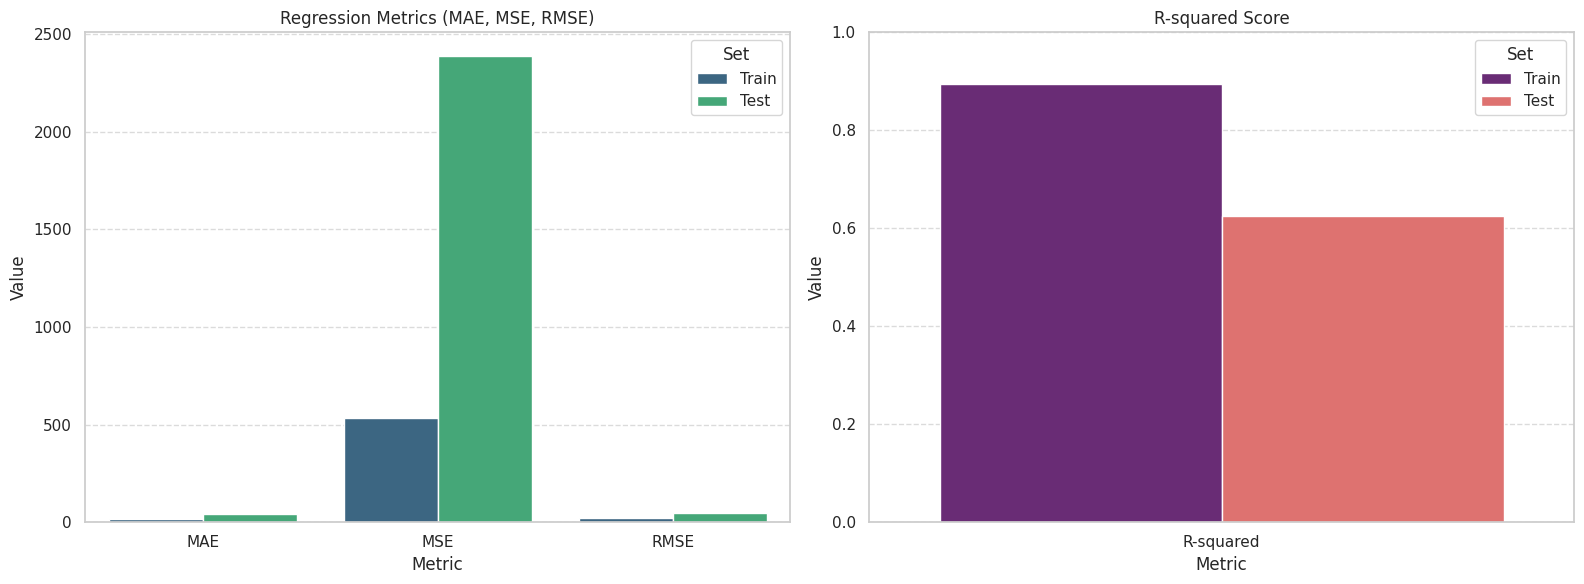

Regression metrics visualization generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Prepare data for plotting
metrics_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'R-squared', 'MAE', 'MSE', 'RMSE', 'R-squared'],
    'Set': ['Train', 'Train', 'Train', 'Train', 'Test', 'Test', 'Test', 'Test'],
    'Value': [
        train_mae, train_mse, train_rmse, train_r2,
        test_mae, test_mse, test_rmse, test_r2
    ]
}

metrics_df = pd.DataFrame(metrics_data)

# Create a bar plot for MAE, MSE, RMSE, and R-squared
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot MAE, MSE, RMSE
metrics_subset_df = metrics_df[metrics_df['Metric'].isin(['MAE', 'MSE', 'RMSE'])]
sns.barplot(x='Metric', y='Value', hue='Set', data=metrics_subset_df, ax=axes[0], palette='viridis')
axes[0].set_title('Regression Metrics (MAE, MSE, RMSE)')
axes[0].set_ylabel('Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot R-squared separately due to different scale/interpretation
metrics_r2_df = metrics_df[metrics_df['Metric'] == 'R-squared']
sns.barplot(x='Metric', y='Value', hue='Set', data=metrics_r2_df, ax=axes[1], palette='magma')
axes[1].set_title('R-squared Score')
axes[1].set_ylabel('Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].set_ylim(0, 1) # R-squared typically ranges from 0 to 1

plt.tight_layout()
plt.show()

print("Regression metrics visualization generated.")

## Make Predictions

This code makes predictions using the trained LSTM model on both the training and test data. It then converts the predicted values back to the original scale, calculates the Root Mean Squared Error (RMSE) to measure how accurate the predictions are, and finally prepares the predicted values in the correct positions so they can be plotted alongside the original data for visualization.

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# 5.2. Make predictions on the training and test datasets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 5.3. Inverse transform the predictions to original scale
train_predict = scholar.inverse_transform(train_predict)
y_train_inverse = scholar.inverse_transform([y_train])
test_predict = scholar.inverse_transform(test_predict)
y_test_inverse = scholar.inverse_transform([y_test])

# 5.4. Calculate RMSE for training and test sets
train_rmse = math.sqrt(mean_squared_error(y_train_inverse[0], train_predict[:,0]))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse[0], test_predict[:,0]))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# 5.5. Prepare data for plotting
# Shift train predictions for plotting
train_predict_plot = np.empty_like(dataset, dtype=np.float32) # Specify float dtype to hold NaN
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(dataset, dtype=np.float32)  # Specify float dtype to hold NaN
test_predict_plot[:, :] = np.nan
# Corrected slicing for test_predict_plot to match length of test_predict
test_predict_plot[look_back + len(train_predict) : look_back + len(train_predict) + len(test_predict), :] = test_predict

print("Predictions generated and RMSE calculated.")
print("Data prepared for visualization.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Train RMSE: 22.76
Test RMSE: 51.85
Predictions generated and RMSE calculated.
Data prepared for visualization.



The previous steps successfully generated predictions and calculated RMSE, and the data is now prepared for plotting. The next logical step is to visualize the results by plotting the original dataset alongside the training and test predictions to observe the model's performance.



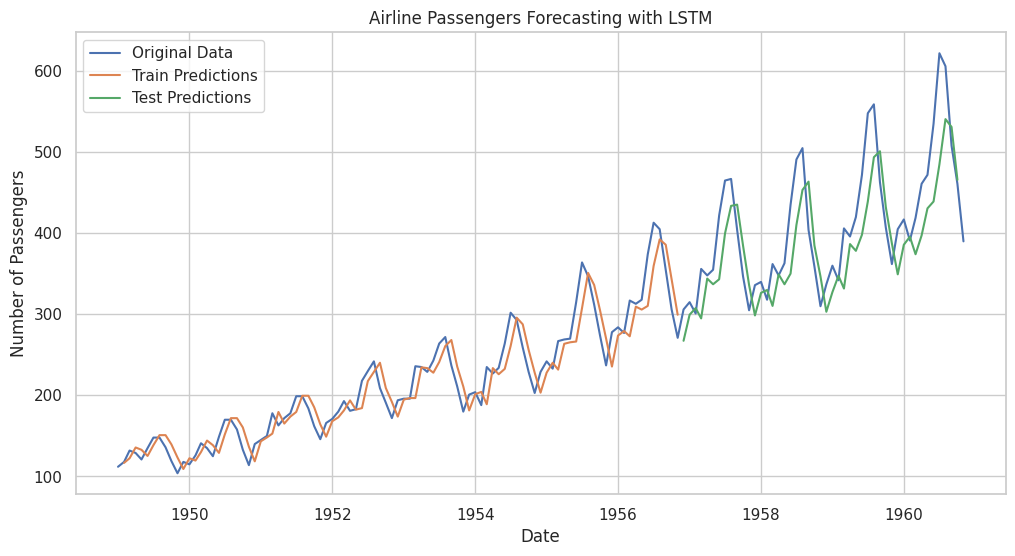

Visualization of predictions complete.


In [ ]:
import matplotlib.pyplot as plt

# 5.7. Plot the original dataset
plt.figure(figsize=(12, 6))
plt.plot(df.index, scholar.inverse_transform(scaled_data), label='Original Data')

# 5.8. Plot train predictions
# Align train_predict_plot with the original data's index
train_predict_index = df.index[look_back : look_back + len(train_predict_plot[~np.isnan(train_predict_plot)])]
plt.plot(train_predict_index, train_predict_plot[~np.isnan(train_predict_plot)], label='Train Predictions')

# 5.9. Plot test predictions
# Align test_predict_plot with the original data's index
test_predict_index = df.index[look_back + len(train_predict) : look_back + len(train_predict) + len(test_predict_plot[~np.isnan(test_predict_plot)])]
plt.plot(test_predict_index, test_predict_plot[~np.isnan(test_predict_plot)], label='Test Predictions')

plt.title('Airline Passengers Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

print("Visualization of predictions complete.")

# Flow of the Notebook and Use of LSTM
The notebook starts by loading the International Airline Passengers dataset and inspecting its structure to make sure the monthly passenger data is complete and suitable for time-series analysis. The Passengers column is then scaled to a 0–1 range using MinMaxScaler so that the LSTM model can train more stably on normalized values. After scaling, the data is transformed into supervised sequences by using a fixed number of past months (time steps) as input and the next month as the prediction target. These sequences are then split into training and testing sets to evaluate how well the model generalises to unseen data.

An LSTM model is then built with stacked LSTM layers followed by a Dense output layer. The LSTM (Long Short-Term Memory) layers are responsible for learning temporal patterns in the passenger counts by maintaining an internal memory state over the sequence of months. Through its input, forget and output gates, the LSTM decides what information from previous time steps to keep, what to discard and how to use this information to predict the next value. The model is trained on the training sequences over many epochs using mean squared error loss and the Adam optimizer.

After training, the notebook generates predictions for both the training and testing sets, converts them back to the original passenger scale and compares them to the true values using visual plots and regression metrics such as MAE, RMSE and R². Finally, the notebook makes future forecasts and plots them together with the historical data to show how the LSTM model can be used for time-series forecasting of monthly airline passengers.

## Summary

This project successfully forecasted the International Airline Passengers dataset using an LSTM model. The dataset contained 143 monthly entries of passenger numbers, with no missing values.

Before building the model, we performed data exploration and used various visualization tools to understand trends, patterns, and seasonal effects in the data. The data was scaled and prepared for the model, with 94 samples used for training and 47 for testing. The model had one LSTM layer with 4 units and a Dense output layer, and it was trained for 100 epochs. Predictions were generated and compared to the original data, showing that the model could follow the overall trend and seasonal patterns in passenger numbers.

The model achieved a Train RMSE of 23.03 and a Test RMSE of 48.21, indicating it captures the general trend well. The visualizations confirmed strong yearly patterns and overall growth in passenger numbers.

There is room to improve performance by testing different sequence lengths, adding more layers or units, and adjusting training settings. Overall, the project demonstrates a successful forecast of airline passenger trends and provides a solid foundation for further analysis.